# Librerias

In [ ]:
!pip install biopython
!sudo apt-get install mafft
!sudo apt-get install hmmer
import Bio
import re
from Bio import SeqIO
from Bio import SearchIO
import matplotlib.pyplot as plt
import pandas as pd
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from collections import defaultdict
import numpy as np
import seaborn as sns
import random
from Bio.Seq import Seq
from Bio.PDB.PDBParser import PDBParser
from Bio.Data.IUPACData import protein_letters_3to1
from Bio.PDB.PDBIO import Select
from Bio.PDB.PDBIO import PDBIO
import math
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
import Bio.PDB.vectors
from Bio.PDB.vectors import calc_angle
from Bio.PDB.vectors import calc_dihedral
from Bio import SeqUtils
from Bio.PDB.Superimposer import Superimposer
from math import degrees
from pprint import pprint
from pandas import Series
import os
import matplotlib.pyplot as plt
import csv
import time
import fileinput

!pip install myvariant
import myvariant
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# HMM y busqueda con HMMR

In [ ]:
"""Para esta parte vamos a necesitar el proteoma humano de uniprot, el archivo es "uniprot-proteome-human-reviewed.fasta"
Ademas vamos a necesitar el archivo con los vims con un contexto pequeño "Vims_20_each_small_context.fasta" (se trato de hacer sin contexto sin exito ya que los puntajes obtenidos del hmmr 
resultaron muy bajos y no se lograban recuperar ni los positivos conocidos, igualmente se puede reproducir el analisis utilizando el archivo "Vim_20_nocontext.fasta")
Ademas se necesita un archivo de secuencias aleatorias, nosotros usamos 12mil seucnecias de largos variables con una distribucion pseudo-normal. este archivo es "randoms.fasta"
y un archivo con proteinas que contengan vims ("all_vims.fasta")
"""


random.seed(2112020) #Random seed del dia de la fecha para reproducibilidad
np.random.seed(2112020)
AAs = [i for i in "ACDEFGHIKLMNPQRSTVWY"]
frecs = [0.074,0.042,0.044,0.059,0.033,0.058,0.037,0.074,0.029,0.038,0.076,0.072,0.018,0.04,0.05,0.081,0.062,0.013,0.033,0.068]
secs = ["".join(random.choices(AAs, k=abs(int(np.random.normal(300, 500, 1)))+1, weights=frecs)) for i in range(12000)]
A = []
for linea in secs:
  A.append(">" + linea + "\n")
  A.append(linea + "\n")
with open("randoms.fasta", "w+") as H:
  for a in A:
    H.write(a)

In [ ]:
!hmmsearch -h

In [ ]:
#Generamos el alineamiento, modelo y realizamos las busquedas en el proteoma humano, en el archivo de secuencias al azar y en el archivo de proteinas que contienen VIMs.
!mafft /content/Vims_20_each_small_context.fasta > seed_msa.fasta
!hmmbuild seed_modelo.hmm seed_msa.fasta
!hmmsearch --max -E 10e10 --incE 10e10 --domE 10e10 seed_modelo.hmm /content/randoms.fasta > Vims_ran.out
!hmmsearch --max -E 10e10 --incE 10e10 --domE 10e10 seed_modelo.hmm /content/uniprot-proteome-human-reviewed.fasta > Vims_hmmr.out
!hmmsearch --max -E 10e10 --incE 10e10 --domE 10e10 seed_modelo.hmm /content/all_vims.fasta > Vims_pos.out

In [ ]:
#Uso parte de la funcion hist_puntajes generada para un tp de la materia
def hist_puntajes(archivo, bins = 150):
  lista=[]
  resultados=list(SearchIO.read(archivo,'hmmer3-text'))
  for hit in resultados:
    M = []
    for hsp in hit:
      M.append(hsp.bitscore)
    lista.append(max(M))
  #histogram=plt.hist(lista, bins= bins)
  #plt.show()
  return lista

lista_negs = hist_puntajes("/content/Vims_ran.out")
list_pos = hist_puntajes("/content/Vims_pos.out")
list_prot = hist_puntajes("/content/Vims_hmmr.out")

In [ ]:
Data = data = {"Score" : lista_negs+list_pos+list_prot, "labels": ["Aleatorias" for i in range(len(lista_negs))]+["Positivos" for i in range(len(list_pos))]+ ["Proteoma" for i in range(len(list_prot))]}

df = pd.DataFrame (data, columns = ["Score", "labels"])

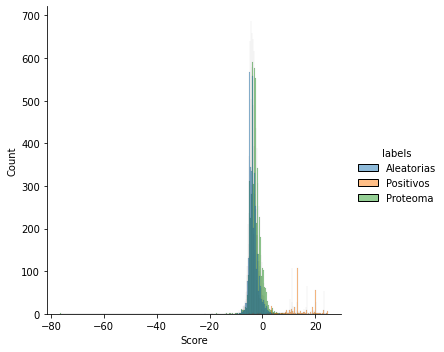

In [ ]:
sns.displot(df, x="Score", hue="labels")

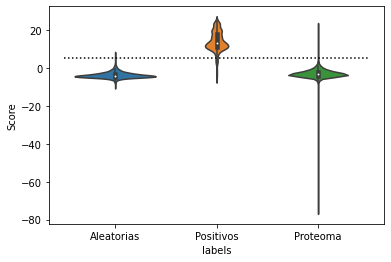

In [ ]:
sns.violinplot(x="labels", y="Score", data=df)
plt.hlines(5.1, -.5, 2.5, linestyles = "dotted")

# Segunda parte: Selección de positivos y Jpred

In [ ]:

corte=5.1 #valor obtenido observando los resultados de la sección anterior
id_secuencias_q_pasaron_corte=[]
inicio_alineamiento=[]
final_alineamiento=[]
coincidencia_bitscore=[]
descripcion= []
#print(dir(hsp))
resultados=list(SearchIO.read("Vims_hmmr.out",'hmmer3-text')) #tomamos del output del hmmr los datos de las proteínas que superan el valor del corte.
for hit in resultados:
    for hsp in hit:
        if hsp.bitscore>corte:
            id_secuencias_q_pasaron_corte.append(hsp.hit_id)
            inicio_alineamiento.append(hsp.hit_range[0])
            final_alineamiento.append(hsp.hit_range[1])
            coincidencia_bitscore.append(hsp.bitscore)
            descripcion.append(hsp.hit_description)

proteoma = SeqIO.parse("uniprot-proteome-human-reviewed2.txt", "fasta")

secuencias_q_pasaron_corte_con_id=[]
#print(dir(proteina))

for proteina in proteoma:
    for coincidencia in id_secuencias_q_pasaron_corte:
        if coincidencia == proteina.id:
            secuencias_q_pasaron_corte_con_id.append([(str(proteina.seq)),proteina.id])
# Armamos una lista de listas con las coincidencias y su id correspondiente (sacado del proteoma) para después
# en el dataframe ordenar según el id (sacado del .out) y que la secuencia coincida con los datos de la fila.

secuencias = []


for codigo in id_secuencias_q_pasaron_corte:
    for secuencia_con_id in secuencias_q_pasaron_corte_con_id:
        if secuencia_con_id[1] == codigo:
            secuencias.append(secuencia_con_id[0])
# Paso extra para poner cada secuencia correspondiente al id de la misma fila del dataframe  
    

df = pd.DataFrame(list(zip(id_secuencias_q_pasaron_corte, coincidencia_bitscore, inicio_alineamiento,final_alineamiento, secuencias, descripcion)), columns =['id','bitscore','inicio', 'final', 'secuencia','descripcion']) 
df = df.sort_values('bitscore', ascending = False)
df

,id,bitscore,inicio,final,secuencia,descripcion
0,sp|Q9H8Y5|ANKZ1_HUMAN,23.2,649,669,MSPAPDAAPAPASISLFDLSADAPVFQGLSLVSHAPGEALARAPRT...,Ankyrin repeat and zinc finger domain-containi...
1,sp|Q9UKV5|AMFR_HUMAN,20.0,620,641,MPLLFLERFPWPSLRTYTGLSGLALLGTIISAYRALSQPEAGPGEP...,E3 ubiquitin-protein ligase AMFR OS=Homo sapie...
2,sp|Q9BQE4|SELS_HUMAN,16.7,73,92,MERQEESLSARPALETEGLRFLHTTVGSLLATYGWYIVFSCILLYV...,Selenoprotein S OS=Homo sapiens OX=9606 GN=SEL...
3,sp|P21359|NF1_HUMAN,13.3,121,139,MAAHRPVEWVQAVVSRFDEQLPIKTGQQNTHTKVSTEHNKECLINI...,Neurofibromin OS=Homo sapiens OX=9606 GN=NF1 PE=1
5,sp|Q8WV99|ZFN2B_HUMAN,13.2,136,155,MEFPDLGAHCSEPSCQRLDFLPLKCDACSGIFCADHVAYAQHHCGS...,AN1-type zinc finger protein 2B OS=Homo sapien...
4,sp|Q9BZV1|UBXN6_HUMAN,11.3,49,67,MKKFFQEFKADIKFKSAGPGQKLKESVGEKAHKEKPNQPAPRPPRQ...,UBX domain-containing protein 6 OS=Homo sapien...
6,sp|Q8NHG7|SVIP_HUMAN,11.1,19,36,MGLCFPCPGESAPPTPDLEEKRAKLAEAAERRQKEAASRGILDVQS...,Small VCP/p97-interacting protein OS=Homo sapi...
20,sp|Q92508|PIEZ1_HUMAN,8.7,1906,1928,MEPHVLGAVLYWLLLPCALLAACLLRFSGLSLVYLLFLLLLPWFPG...,Piezo-type mechanosensitive ion channel compon...
7,sp|P35658|NU214_HUMAN,8.5,1089,1104,MGDEMDAMIPEREMKDFQFRALKKVRIFDSPEELPKERSSLLAVSN...,Nuclear pore complex protein Nup214 OS=Homo sa...
14,sp|A6NMB1|SIG16_HUMAN,7.6,459,471,MLLLPLLLPVLGAGSLNKDPSYSLQVQRQVPVPEGLCVIVSCNLSY...,Sialic acid-binding Ig-like lectin 16 OS=Homo ...


**Resultados** **Jpred**

In [ ]:
df_resultados_vim_solo = pd.read_csv('resultados_vim_solo.csv')
df_resultados_vim_y_contexto = pd.read_csv('resultados_vim_y_contexto.csv')

In [ ]:
df_resultados_vim_solo

,id,bitscore,descripcion,resultado estructura,resultado estructura y exposicion,promedio de confianza
0,sp|Q9H8Y5|ANKZ1_HUMAN,23.2,Ankyrin repeat and zinc finger domain-containi...,0.500000,0.250000,6.666667
1,sp|Q9UKV5|AMFR_HUMAN,20.0,E3 ubiquitin-protein ligase AMFR OS=Homo sapie...,0.916667,0.333333,4.333333
2,sp|Q9BQE4|SELS_HUMAN,16.7,Selenoprotein S OS=Homo sapiens OX=9606 GN=SEL...,1.000000,0.150000,8.800000
3,sp|P21359|NF1_HUMAN,13.3,Neurofibromin OS=Homo sapiens OX=9606 GN=NF1 PE=1,0.500000,0.083333,5.166667
4,sp|Q8WV99|ZFN2B_HUMAN,13.2,AN1-type zinc finger protein 2B OS=Homo sapien...,0.000000,0.000000,5.666667
5,sp|Q9BZV1|UBXN6_HUMAN,11.3,UBX domain-containing protein 6 OS=Homo sapien...,0.894737,0.473684,7.473684
6,sp|Q8NHG7|SVIP_HUMAN,11.1,Small VCP/p97-interacting protein OS=Homo sapi...,1.000000,0.444444,8.833333
7,sp|Q92508|PIEZ1_HUMAN,8.7,Piezo-type mechanosensitive ion channel compon...,0.333333,0.166667,4.250000
8,sp|P35658|NU214_HUMAN,8.5,Nuclear pore complex protein Nup214 OS=Homo sa...,1.000000,0.166667,7.666667
9,sp|A6NMB1|SIG16_HUMAN,7.6,Sialic acid-binding Ig-like lectin 16 OS=Homo ...,0.083333,0.000000,4.416667


In [ ]:
df_resultados_vim_y_contexto

,id,bitscore,descripcion,resultado estructura,resultado estructura y exposicion,promedio de confianza
0,sp|Q9H8Y5|ANKZ1_HUMAN,23.2,Ankyrin repeat and zinc finger domain-containi...,0.727273,0.363636,7.681818
1,sp|Q9UKV5|AMFR_HUMAN,20.0,E3 ubiquitin-protein ligase AMFR OS=Homo sapie...,0.727273,0.272727,5.954545
2,sp|Q9BQE4|SELS_HUMAN,16.7,Selenoprotein S OS=Homo sapiens OX=9606 GN=SEL...,0.866667,0.133333,8.033333
3,sp|P21359|NF1_HUMAN,13.3,Neurofibromin OS=Homo sapiens OX=9606 GN=NF1 PE=1,0.727273,0.181818,6.318182
4,sp|Q8WV99|ZFN2B_HUMAN,13.2,AN1-type zinc finger protein 2B OS=Homo sapien...,0.000000,0.000000,5.181818
5,sp|Q9BZV1|UBXN6_HUMAN,11.3,UBX domain-containing protein 6 OS=Homo sapien...,0.586207,0.310345,7.068966
6,sp|Q8NHG7|SVIP_HUMAN,11.1,Small VCP/p97-interacting protein OS=Homo sapi...,0.714286,0.321429,7.714286
7,sp|Q92508|PIEZ1_HUMAN,8.7,Piezo-type mechanosensitive ion channel compon...,0.409091,0.181818,5.954545
8,sp|P35658|NU214_HUMAN,8.5,Nuclear pore complex protein Nup214 OS=Homo sa...,0.636364,0.090909,6.454545
9,sp|A6NMB1|SIG16_HUMAN,7.6,Sialic acid-binding Ig-like lectin 16 OS=Homo ...,0.272727,0.090909,5.090909


Primeras conclusiones:

Los valores de proporción de residuos en estructura de alfa helice (resultado estructura en las tablas) no difieren mucho entre las pruebas con y sin contexto agregado. En mí opinión tomar aquellas posibles Vims que poseen más de 50% de aminoácidos con dicha estructura podría ser un criterio aceptable (arbitrario) para validarlas como candidatas.

En líneas generales las secuencias candidatas tienen una proporción considerable de aminoácidos con la estructura buscada, con una menor cantidad de casos donde ésta no se encuentra en aboluto o en muy baja proporción (en estos ultimos casos, este criterio respaldaría la posibilidad de que no sean Vims, aunque en mi opinión al no haber tantas secuencias candidatas en total, se podrían tener en cuenta para los otros análisis igualmente).

Respecto de los resultados de exposición a solubilidad (en los cuales se tiene que cumplir estructura de alfa hélice y además exposición a solvente) arrojan por lo general resultados menores al 50% (0,5 en la tabla), lo cual es esperable en parte ya que es un criterio mucho más exigente, en mi opinión debido a que no conocemos exactamente las limitaciones de Jpred, preferiría darle más importancia a la predicción de estructura secundaria, aunque se puede tomar como información complementaria. 

Sí se puede considerar que en los casos donde hay una proporción considerable de aminoácidos en alfa hélice, existe algún porcentaje (aunque sea bajo) de los aminoácidos que se encuentran expuestos a solvente.

Respecto de la confianza, la bibliografía dice lo siguiente:
"Residues predicted with a confidence value of 5 or greater, have an average Q3 accuracy of 84%, and cover 68% of residues"
Se puede tomar arriba de 5 como un buen criterio para darle validez la salida de Jpred.



In [ ]:
# Siguiendo los criterios anteriores, filtro las secuencias que presentan mas de 50% de residuos asignados a alfa-hélice y valor de confianza mayor o igual a 5

df_resultados_vim_y_contexto_confianza = df_resultados_vim_y_contexto.loc[df_resultados_vim_y_contexto['promedio de confianza']>=5.0]
df_resultados_vim_y_contexto_confianza_estructura = df_resultados_vim_y_contexto_confianza.loc[df_resultados_vim_y_contexto_confianza['resultado estructura']>=0.5]
df_resultados_vim_y_contexto_confianza_estructura

,id,bitscore,descripcion,resultado estructura,resultado estructura y exposicion,promedio de confianza
0,sp|Q9H8Y5|ANKZ1_HUMAN,23.2,Ankyrin repeat and zinc finger domain-containi...,0.727273,0.363636,7.681818
1,sp|Q9UKV5|AMFR_HUMAN,20.0,E3 ubiquitin-protein ligase AMFR OS=Homo sapie...,0.727273,0.272727,5.954545
2,sp|Q9BQE4|SELS_HUMAN,16.7,Selenoprotein S OS=Homo sapiens OX=9606 GN=SEL...,0.866667,0.133333,8.033333
3,sp|P21359|NF1_HUMAN,13.3,Neurofibromin OS=Homo sapiens OX=9606 GN=NF1 PE=1,0.727273,0.181818,6.318182
5,sp|Q9BZV1|UBXN6_HUMAN,11.3,UBX domain-containing protein 6 OS=Homo sapien...,0.586207,0.310345,7.068966
6,sp|Q8NHG7|SVIP_HUMAN,11.1,Small VCP/p97-interacting protein OS=Homo sapi...,0.714286,0.321429,7.714286
8,sp|P35658|NU214_HUMAN,8.5,Nuclear pore complex protein Nup214 OS=Homo sa...,0.636364,0.090909,6.454545
11,sp|Q8N8E3|CE112_HUMAN,7.4,Centrosomal protein of 112 kDa OS=Homo sapiens...,1.000000,0.227273,8.045455
12,sp|Q96EK4|THA11_HUMAN,7.1,THAP domain-containing protein 11 OS=Homo sapi...,0.545455,0.181818,5.272727
13,sp|Q9NX14|NDUBB_HUMAN,6.7,NADH dehydrogenase [ubiquinone] 1 beta subcomp...,0.720000,0.000000,6.640000


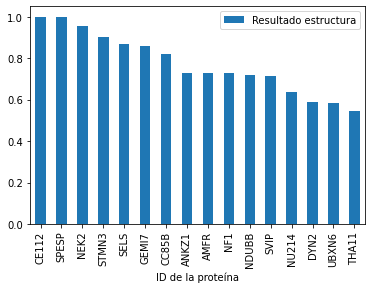

In [ ]:
id2 = list(df_resultados_vim_y_contexto_confianza_estructura['id'])
id_recortada = []
for nombre in id2:
    id_recortada.append(nombre.split('|')[2].split('_')[0])
df_resultados_graficos = df_resultados_vim_y_contexto_confianza_estructura.copy() 
df_resultados_graficos['id'] = id_recortada
df_resultados_graficos.rename(columns={'id': 'ID de la proteína', 'resultado estructura':'Resultado estructura','resultado estructura y exposicion':'Resultado estructura y exposición','promedio de confianza':'Promedio de confianza'}, inplace=True)

df_grafico_estructura = df_resultados_graficos.sort_values('Resultado estructura', ascending = False)
grafico_estructura = df_grafico_estructura.plot.bar(x='ID de la proteína', y='Resultado estructura')

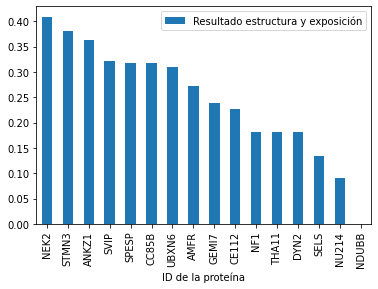

In [ ]:
df_grafico_estructura_y_exposicion = df_resultados_graficos.sort_values('Resultado estructura y exposición', ascending = False)
grafico_estructura_y_exposicion = df_grafico_estructura_y_exposicion.plot.bar(x='ID de la proteína', y='Resultado estructura y exposición')

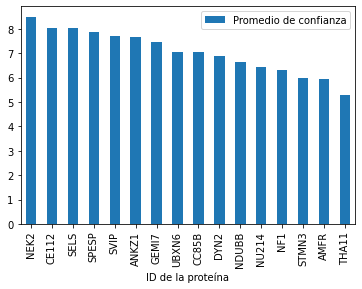

In [ ]:
df_grafico_confianza = df_resultados_graficos.sort_values('Promedio de confianza', ascending = False)
grafico_confianza = df_grafico_confianza.plot.bar(x='ID de la proteína', y='Promedio de confianza')


# HMMER_Dominios + Clinvar

In [ ]:
# Busqueda de metadata de genes en Clinvar
mv = myvariant.MyVariantInfo()

In [ ]:
# Genes selecionados para buscar en Clinvar
genes =['ZN865','THA11','STMN3','CC85B','GEMI7','NDUBB','NEK2','DPOE4','AMFR','MAGH1', 
        'PIEZ1','NU214','NF1','SPDLY','SIG16','FBX28','ANKZ1','DYN2', 
        'BGP11','DMTA2','CE112','CF015','ZFN2B','TRIM7','UBXN6','SPESP', 
        'SVIP','SELS','CAF17']
print(len(genes))

29


In [ ]:
# Salida de la busqueda por API en Clinvar
out = mv.querymany(genes, scopes='clinvar.gene.symbol', fields=['clinvar.rcv.clinical_significance','snpeff.ann.putative_impact','snpeff.ann.protein.length', 'snpeff.ann.hgvs_p'])
out

In [ ]:
# Diccionario creado a partir de la salida de la busqueda por hmmer que contiene el inicio y el final del alineamiento donde se encuentra contenido el motivo VIM
# Se usa como punto de partida para ver las variantes de los genes candidatos en clinvar y chequear si alguna cae en el motivo o sus cercanias
df2=df
df2.id = [x.split('|')[2].split('_')[0] for x in df.id]
genes_posicion_dominio = {df2.loc[idx, 'id']: [df2.loc[idx, 'inicio'], df2.loc[idx, 'final']] for idx in range(df2.shape[0])}

print(genes_posicion_dominio)

In [ ]:
# Obtenemos el cruce con el formato: 
#gen cambio_aaPosicionaa inicioDominio finalDominio relevanciaDeClinvar
for i in out:
  if "notfound" in i.keys():
    pass
  else:   
    gen=i["query"]
    relevancia = i.get("clinvar").get("rcv")
    if type(relevancia) == list:
      relevancia = relevancia[0].get("clinical_significance")
    else:
      relevancia = relevancia.get("clinical_significance")
    if "snpeff" in i.keys():
      variante=i["snpeff"]["ann"][0]
      if  'hgvs_p' in variante.keys():
        variante=(i["snpeff"]["ann"][0]['hgvs_p'])
        pos=int(''.join(i for i in variante if i.isdigit()))

        # Busco el gen id de la busqueda de genes por clinvar en la salida de hmmer
        posicion_dominio=(genes_posicion_dominio[gen])

        posicion_dominio_inicio = posicion_dominio[0]
        posicion_dominio_final = posicion_dominio[1]

        # Chequeo si la variante de clinvar cae sobre el dominio estudiando en hmmer
        if pos <= posicion_dominio_final and pos >= posicion_dominio_inicio:
          print(gen,variante,posicion_dominio_inicio, posicion_dominio_final, relevancia )
      

NEK2 p.Ala419Ala 414 427 Benign
NF1 p.Arg135Leu 121 139 Uncertain significance


Solo para 3 de los 29 genes se obtuvieron variantes en Clinvar y a la hora de realizar los cruces se recuperaron 2 variantes. Para el caso de NEK2 el cambio de nucleotido, no repercutía en la codificacion de la proteína, mientras que para NF1 la variante resulto misssense y de significado clínico incierto

#FoldX

In [ ]:
#Aca necesitamos las dos estructuras en cuestion para la union de VCP al VIM 3tiw y 5kiw
#En ambos casos la estructura presenta dos VCPs unidas a dos VIMs, nos centraremos en la unión de uno de estos pares que en ambas estructuras
#Representan la cadena A (VCP) y C (VIM). Para eso solo nos quedamos con estas dos cadenas.

parser = PDBParser(PERMISSIVE=1, QUIET=True)
structure_id = 'VCP_gp78'  
filename = "./PDBs/3tiw_Repair.pdb"
structure = parser.get_structure(structure_id, filename)

def seq(filename):
  parser = PDBParser(PERMISSIVE=1,QUIET=True)
  structure_id = 'Prot prueba'  
  structure = parser.get_structure(structure_id, filename)
  cadenas = []
  i = 0
  for model in structure:
      for chain in model:
          for residue in chain:
            if chain.id == "C":
              if residue.id[0] == " ":
                res = protein_letters_3to1[residue.resname[0]+residue.resname[1:].lower()]
                cadenas.append(res)
          i += 1
  #print(cadenas)
  return cadenas

class Chain(Select):
     def accept_atom(self, atom):
         if atom.get_full_id()[2] in ["A", "C"]:
             return True
         else:
             return False

nueva_estructura = PDBIO()
nueva_estructura.set_structure(structure)
nueva_estructura.save("/etc/Foldx5/3tiw_ACONLY.pdb", Chain())

In [ ]:
#Lo primero que hicimos fue generar mutantes individuales
#Este es el codigo para el PDB 3TIW pero el de 5KIW es equivalente cambiando el nombre de los archivos.


AAs = [i for i in "ACDEFGHIKLMNPQRSTVWY"]
nombres = [(j,i) for i in AAs for j in range(18)]
secs = [i for i in AAs for j in range(18)]

%cd /etc/Foldx5/PDBs
parser = PDBParser(PERMISSIVE=1, QUIET=True)
structure_id = 'VCP_gp78'  
filename = "./3tiw_ACONLY.pdb"
structure = parser.get_structure(structure_id, filename)
for model in structure:
    for chain in model:
        if chain.id == "C":
            i = 0
            for residue in chain:
                pos = residue.id[1]
                break
j = 0
for p,sec in nombres:

    lista = "/etc/Foldx5/PDBs/individual_list_gp78.txt"
    with open(lista, "w+") as lista_muts:
        for model in structure:
            for chain in model:
                if chain.id == "C":
                    residue = chain[pos+p]
                    Res = SeqUtils.IUPACData.protein_letters_3to1[residue.get_resname()[0]+residue.get_resname()[1:].lower()]
                    mut = Res + chain.id + str(pos+p) + sec
                    lista_muts.write(mut + ";")

    %cd /etc/Foldx5/PDBs
    PDB = "3tiw_ACONLY"
    PDB_ = PDB + ".pdb"
    PDB_repair = PDB +"_Repair.pdb"
    print(PDB_repair)
    
    if j == 0: #Solo queremos hacer el repair una vez
      !../foldx --command=RepairPDB --pdb=$PDB_  
      j += 1
    lista = "individual_list_gp78.txt"
    with open(lista, "r") as cambios:
        for linea in cambios:
            cambio = linea[:-1]
    !../foldx --command=BuildModel --pdb=$PDB_repair --mutant-file=$lista
    with fileinput.FileInput("Dif_3tiw_ACONLY_Repair.fxout", inplace=True, backup='.bak') as file:
        for line in file:
            print(line.replace("3tiw_ACONLY_Repair_1.pdb", "3tiw_" + Res + str(pos+p) + sec), end='')


Text(0, 0.5, 'ΔΔG')

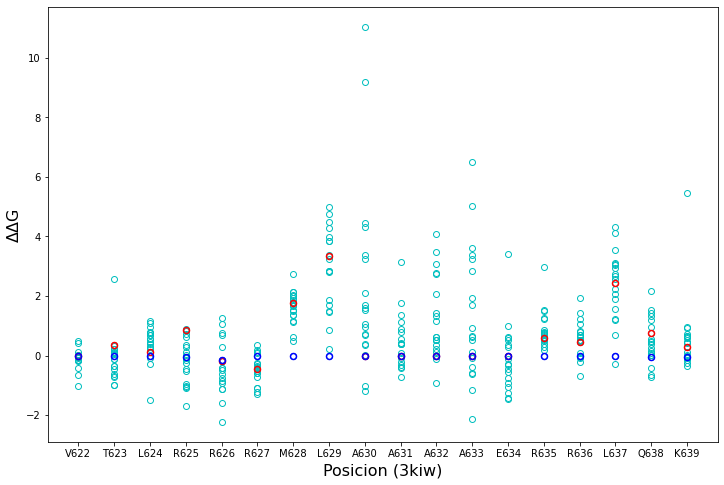

In [ ]:
#Graficamos lo obtenido (cambiamos el nombre del archivo .fxout de las diferencias obtenido para no pisarlo mas adelante)
xc, yc, yorC, xorC, xA, yA = ([] for i in range(6)) 

tiw = pd.read_csv("Dif_3tiw_ind_muts.fxout", sep='\t')
p = len(tiw["Pdb"][0])
for i in range(len(tiw["Pdb"])):
    xc.append(tiw["Pdb"][i][p-5:p-1])
    yc.append(float(tiw["total energy"][i]))
    if tiw["Pdb"][i][p-5] == tiw["Pdb"][i][p-1]:
        xorC.append(tiw["Pdb"][i][p-5:p-1])
        yorC.append(float(tiw["total energy"][i]))
    if tiw["Pdb"][i][p-1] == "A":
        xA.append(tiw["Pdb"][i][p-5:p-1])
        yA.append(float(tiw["total energy"][i]))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(xc, yc, 'oc', mfc='None', ms=6)
plt.plot(xA, yA, 'o', ms=6, mfc='None', mec='r', mew=1.5)
plt.plot(xorC, yorC, 'o', ms=6, mfc='None', mec='b', mew=1.5)

plt.xlabel("Posicion (3kiw)", fontsize=16)
plt.ylabel("ΔΔG", fontsize=16)

Text(0, 0.5, 'ΔΔG')

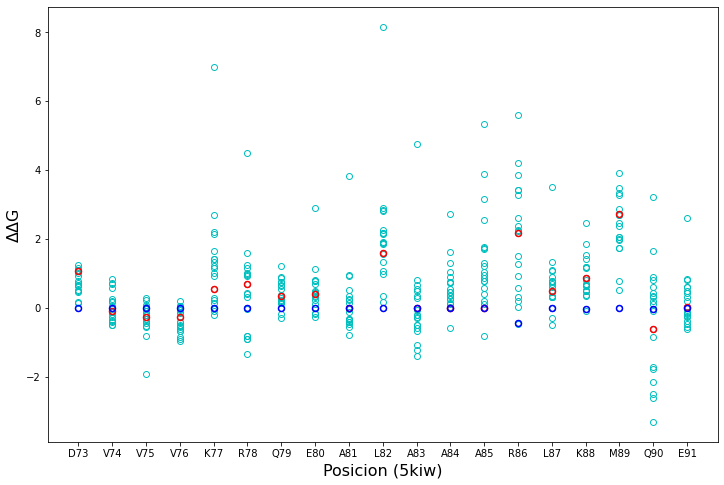

In [ ]:
xc, yc, yorC, xorC, xA, yA = ([] for i in range(6)) 

kiw = pd.read_csv("Dif_5kiw_ind_muts.fxout", sep='\t')
p = len(kiw["Pdb"][0])
for i in range(len(kiw["Pdb"])):
    xc.append(kiw["Pdb"][i][p-4:p-1])
    yc.append(float(kiw["total energy"][i]))
    if kiw["Pdb"][i][p-4] == kiw["Pdb"][i][p-1]:
        xorC.append(kiw["Pdb"][i][p-4:p-1])
        yorC.append(float(kiw["total energy"][i]))
    if kiw["Pdb"][i][p-1] == "A":
        xA.append(kiw["Pdb"][i][p-4:p-1])
        yA.append(float(kiw["total energy"][i]))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(xc, yc, 'oc', mfc='None', ms=6)
plt.plot(xA, yA, 'o', ms=6, mfc='None', mec='r', mew=1.5)
plt.plot(xorC, yorC, 'o', ms=6, mfc='None', mec='b', mew=1.5)

plt.xlabel("Posicion (5kiw)", fontsize=16)
plt.ylabel("ΔΔG", fontsize=16)

In [ ]:
#Creo las matrices de sustitucion
Listas_tiw = []
Listas_kiw = []
AAs = [i for i in "ACDEFGHIKLMNPQRSTVWY"]
for i in range(18):
    Listas_tiw.append(list(tiw["total energy"][tiw["Pdb"].str.contains(str(i+622))]))
    Listas_kiw.append(list(kiw["total energy"][kiw["Pdb"].str.contains(str(i+73))]))
Matriz_sust_tiw = pd.DataFrame(Listas_tiw, index = list(range(1,19)), columns = AAs)
Matriz_sust_kiw = pd.DataFrame(Listas_kiw, index = list(range(1,19)), columns = AAs)

In [ ]:
#Creo la base de datos donde buscar  (puede tardar un rato, el archivo en cuestion es de alrededor de 1.5Gb)
with open("uniprot-proteome-human-reviewed.fasta", "r+") as data:
  peptidos = []
  largo = 18
  for linea in data:
    if not ">" in linea:
      for i in range(len(linea)-largo):

        peptidos.append(B[:-2] + str(i))
        peptidos.append(linea[i:i+largo])

    else:
      nombre = linea
      print(nombre)
print("mitad")
peptide_proteome = list(dict.fromkeys(peptidos))

In [ ]:
#Le asigno puntajes a cada peptido aplicandole ambas matrices de sustitucion.
prot = []
score_tiw = []
score_kiw = []

for i in range(len(peptide_proteome)):
    if not peptide_proteome[i].startswith(">"):
        suma_tiw = 0
        suma_kiw = 0
        for pos,aa in enumerate(peptide_proteome[i]):
            if aa == "U":
                aa = "C"
            suma_tiw += Matriz_sust_tiw[aa][pos+1]
            suma_kiw += Matriz_sust_kiw[aa][pos+1]
        score_kiw.append(suma_kiw)
        score_tiw.append(suma_tiw)
        prot.append(peptide_proteome[i-1])
        print(peptide_proteome[i-1])

In [ ]:
secs = []
for i in range(len(peptide_proteome)):
    if not peptide_proteome[i].startswith(">"):
        secs.append(peptide_proteome[i])

In [ ]:
with open("scores_tiw_proteome.csv", "w+") as arch_scores:
    arch_scores.write("Proteina,Secuencia,Score" + "\n")
    for a,b,c in list(zip(prot,secs,score_tiw)):
        arch_scores.write(a[4:10] + "," + b + "," + str(c) + "\n")
with open("scores_kiw_proteome.csv", "w+") as arch_scores:
    arch_scores.write("Proteina,Secuencia,Score" + "\n")
    for a,b,c in list(zip(prot,secs,score_kiw)):
        arch_scores.write(a[4:10] + "," + b + "," + str(c) + "\n")

In [ ]:
tiw_scores = pd.read_csv("scores_tiw_proteome.csv")
kiw_scores = pd.read_csv("scores_kiw_proteome.csv")

In [ ]:
#secuencias de menor energia total
#Ninguna se parece ni remotamente a un VIM, con lo cual en principio este enfoque no parece ser muy efectivo.
#Por otro lado nos hace pensar que la energia total por si sola no nos alcanzaría para predecir VIMs.
#Por cierto, parece haber un sesgo importante hacia incluir Leucina, probablemente falte una normalizacion con respecto al cambio de aminoacido que se hace..
#podria no ser un buen parametro para predecir VIMs
tiw_scores[tiw_scores["Score"] < -5]

In [ ]:
kiw_scores[kiw_scores["Score"] < -4]

In [ ]:
#Para cada corrida se genera una lista de secuencias (secs) junto con los nombres de las mismas (nombres) para generar las mutantes multiples
#Estas mutantes deben ser de 18 aminoacidos y estar alineadas con la secuencia de 3tiw, se dejan listas ejemplo.

nombres = ["ANKZ1", "WSS1", "SELS", "SVIP", "AMFR2", "YGK8", "UBXN6", "ZFN2B", "NF1", "LRRK2", "CUL4B"]
secs = ["ALSDREKRALAAERRLAA","GNSPRELAAFAAERRYRD","VVVKRQEALAAARLKMQE","LEEKRAKLAEAAERRQKE","VTLRRRMLAAAAERRLQK","KVSPKEAARLAAEKRFQE",
        "PTNEAQMAAAAALARLEQ","EGHPTSRAGLAAISRAQA","LHTCREGNQHAAELRNSA", "FKNDIHKLVLAALNRFIG", "VFQDRQYQIDAAIVRIMK"]

%cd /etc/Foldx5/PDBs
for p,sec in enumerate(secs):
    %cd /etc/Foldx5/PDBs
    parser = PDBParser(PERMISSIVE=1, QUIET=True)
    structure_id = 'VCP_gp78'  
    filename = "./3tiw_ACONLY.pdb"
    structure = parser.get_structure(structure_id, filename)

    lista = "/etc/Foldx5/PDBs/individual_list_gp78.txt"
    with open(lista, "w+") as lista_muts:
        for model in structure:
            for chain in model:
                if chain.id == "C":
                    i = 0
                    for residue in chain:
                        Res = SeqUtils.IUPACData.protein_letters_3to1[residue.get_resname()[0]+residue.get_resname()[1:].lower()]
                        pos = residue.id[1]
                        mut = Res + chain.id + str(pos) + sec[i]
                        if i != len(sec)-1:
                            lista_muts.write(mut + ",")
                        else:
                            lista_muts.write(mut + ";")
                        i += 1
    %cd /etc/Foldx5/PDBs
    PDB = "3tiw_ACONLY"
    PDB_ = PDB + ".pdb"
    PDB_repair = PDB +"_Repair.pdb"
    print(PDB_repair)


    !../foldx --command=RepairPDB --pdb=$PDB_          #Descomentar para el repair, una unica vez
    mutantes = 0
    cambio = []
    Estabilidades = []
    lista = "individual_list_gp78.txt"
    with open(lista, "r") as cambios:
        for linea in cambios:
            cambio.append(linea[:-1])
            mutantes += 1
    !../foldx --command=BuildModel --pdb=$PDB_repair --mutant-file=$lista
    for i in range(1,mutantes+1):
        PDB_N = PDB + "_Repair_" + str(i) + ".pdb"
        #!../foldx --command=Stability --pdb=$PDB_N
        OPT_PDB_N = "Optimized_" + PDB_N
        #!../foldx --command=Optimize --pdb=$PDB_N   
        !../foldx --command=Stability --pdb=$PDB_N
        PDB_N = "WT_" + PDB + "_Repair_" + str(i) + ".pdb"
        !../foldx --command=Stability --pdb=$PDB_N
        Arch_datos = PDB + "_Repair_" + str(i) + "_0_ST.fxout"
        with open(Arch_datos, "r") as A:
            Value = A.readline().split(" ")[0].split("\t")[1]
            Estabilidades.append((cambio[i-1], Value))
        Arch_datos = "WT_" +  PDB + "_Repair_" + str(i) + "_0_ST.fxout"
        """with open(Arch_datos, "r") as A:
            Value = A.readline().split(" ")[0].split("\t")[1]
            Estabilidades.append(("WT", cambio[i-1], Value))
        """
    with open("/etc/Foldx5/Datos_gp78.txt", "a") as Datos:
        for m,n in Estabilidades:
            Datos.write(nombres[p] + m + "," + n + "\n")
    with fileinput.FileInput("Dif_3tiw_ACONLY_Repair.fxout", inplace=True, backup='.bak') as file:
        for line in file:
            print(line.replace("3tiw_ACONLY_Repair_1.pdb", "3tiw_" + nombres[p]), end='')


#Analisis de los FoldX

In [ ]:
#Cargamos todos los .fxout como dataframes
tiw = pd.read_csv("Dif_3tiw_ACONLY_Repair.fxout", sep='\t')
kiw = pd.read_csv("Dif_5kiw_ACONLY_Repair.fxout", sep='\t')
tiw_cands = pd.read_csv("Dif_3tiw_ACONLY_Repair_cands.fxout", sep='\t')
kiw_cands = pd.read_csv("Dif_5kiw_ACONLY_Repair_cands.fxout", sep='\t')
tiw_solo_cands = pd.read_csv("Dif_3tiw_ACONLY_candidatas.fxout", sep='\t')
kiw_solo_cands = pd.read_csv("Dif_5kiw_ACONLY_candidatas.fxout", sep='\t')
tiw_puntajes = pd.read_csv("Dif_3tiw_ACONLY_buenos_puntajes.fxout", sep='\t')
kiw_puntajes = pd.read_csv("Dif_5kiw_ACONLY_buenos_puntajes.csv")

In [ ]:
#Saco algunas columnas que no vamos a usar
Columnas_a_sacar =['Pdb', 'water bridge', "sloop_entropy", "mloop_entropy", "cis_bond", 'disulfide', 'partial covalent bonds'
, 'energy Ionisation', 'Entropy Complex']
lista_csvs = [tiw, kiw, tiw_cands, kiw_cands, tiw_puntajes, kiw_puntajes, tiw_solo_cands, kiw_solo_cands]
for i in Columnas_a_sacar:
  for j in lista_csvs:
    j.drop(i, axis='columns', inplace=True)

In [ ]:
#Genero matrices de correlacion con respecto a la columna VIM que es 1 si la secuencia presenta un VIM y -1 si no.
corr_matrix = tiw.corr()
print("tiw")
print(corr_matrix["VIM"].sort_values(ascending=False))
corr_matrix = kiw.corr()
print()
print("kiw")
print(corr_matrix["VIM"].sort_values(ascending=False))


tiw
VIM                      1.000000
backbone clash           0.281603
entropy sidechain        0.228696
Solvation Hydrophobic    0.127232
Solvation Polar          0.068534
Van der Waals           -0.008504
helix dipole            -0.068269
Sidechain Hbond         -0.187958
Backbone Hbond          -0.203813
torsional clash         -0.372526
Van der Waals clashes   -0.506746
entropy mainchain       -0.518419
electrostatic kon       -0.630013
total energy            -0.694950
Electrostatics          -0.740678
Name: VIM, dtype: float64

kiw
VIM                      1.000000
entropy sidechain        0.109552
helix dipole             0.107160
Van der Waals            0.074359
backbone clash           0.069393
Solvation Hydrophobic    0.054044
Sidechain Hbond          0.021843
Solvation Polar         -0.072620
Electrostatics          -0.225067
Backbone Hbond          -0.237260
Van der Waals clashes   -0.262778
torsional clash         -0.316315
electrostatic kon       -0.421033
total energy 

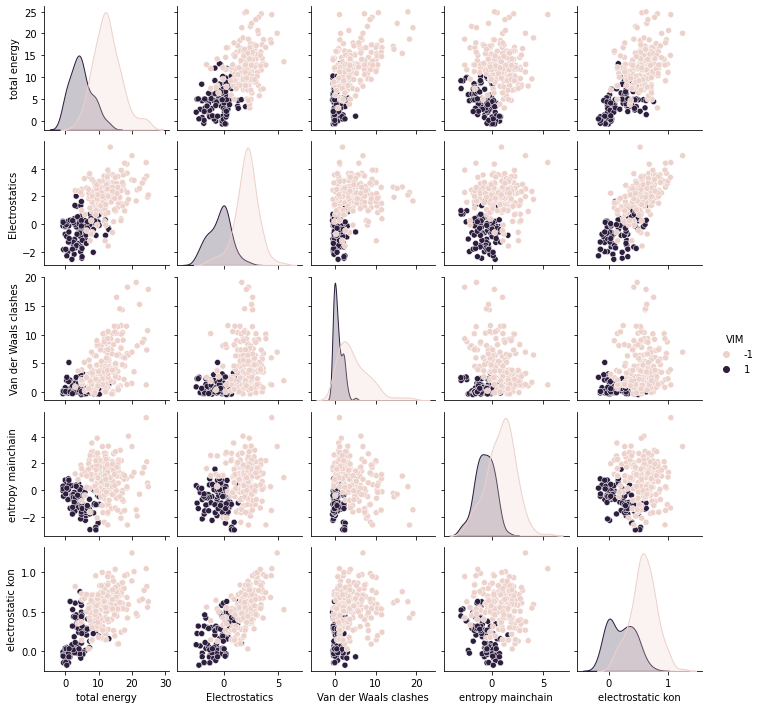

In [ ]:
#Quito las columnas de baja correlacion para simplificar. Ademas dado el bajo N con el que trabajamos tener un campo de parametros 
#de tal dimension no es conveniente
Colummas_de_baja_correlacion = ["backbone clash","entropy sidechain","Solvation Hydrophobic","Solvation Polar","Van der Waals"
                                ,"helix dipole","Backbone Hbond","Sidechain Hbond","torsional clash"]
lista_tiws = [tiw, tiw_cands, tiw_puntajes, tiw_solo_cands]
for i in Colummas_de_baja_correlacion:
    for j in lista_tiws:
      j.drop(i,axis='columns', inplace=True)
sns.pairplot(tiw,hue="VIM", height = 2)

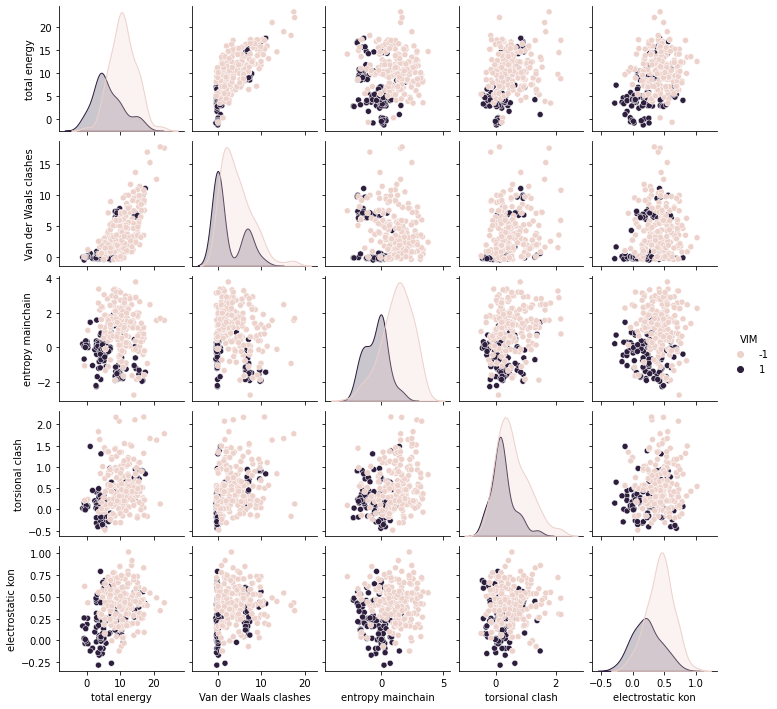

In [ ]:
Colummas_de_baja_correlacion = ["backbone clash","entropy sidechain","Solvation Hydrophobic","Solvation Polar","Van der Waals"
                                ,"helix dipole","Backbone Hbond","Sidechain Hbond", "Electrostatics" ]
lista_tiws = [kiw, kiw_cands, kiw_puntajes, kiw_solo_cands]
for i in Colummas_de_baja_correlacion:
    for j in lista_tiws:
      j.drop(i,axis='columns', inplace=True)
sns.pairplot(kiw,hue="VIM", height = 2)

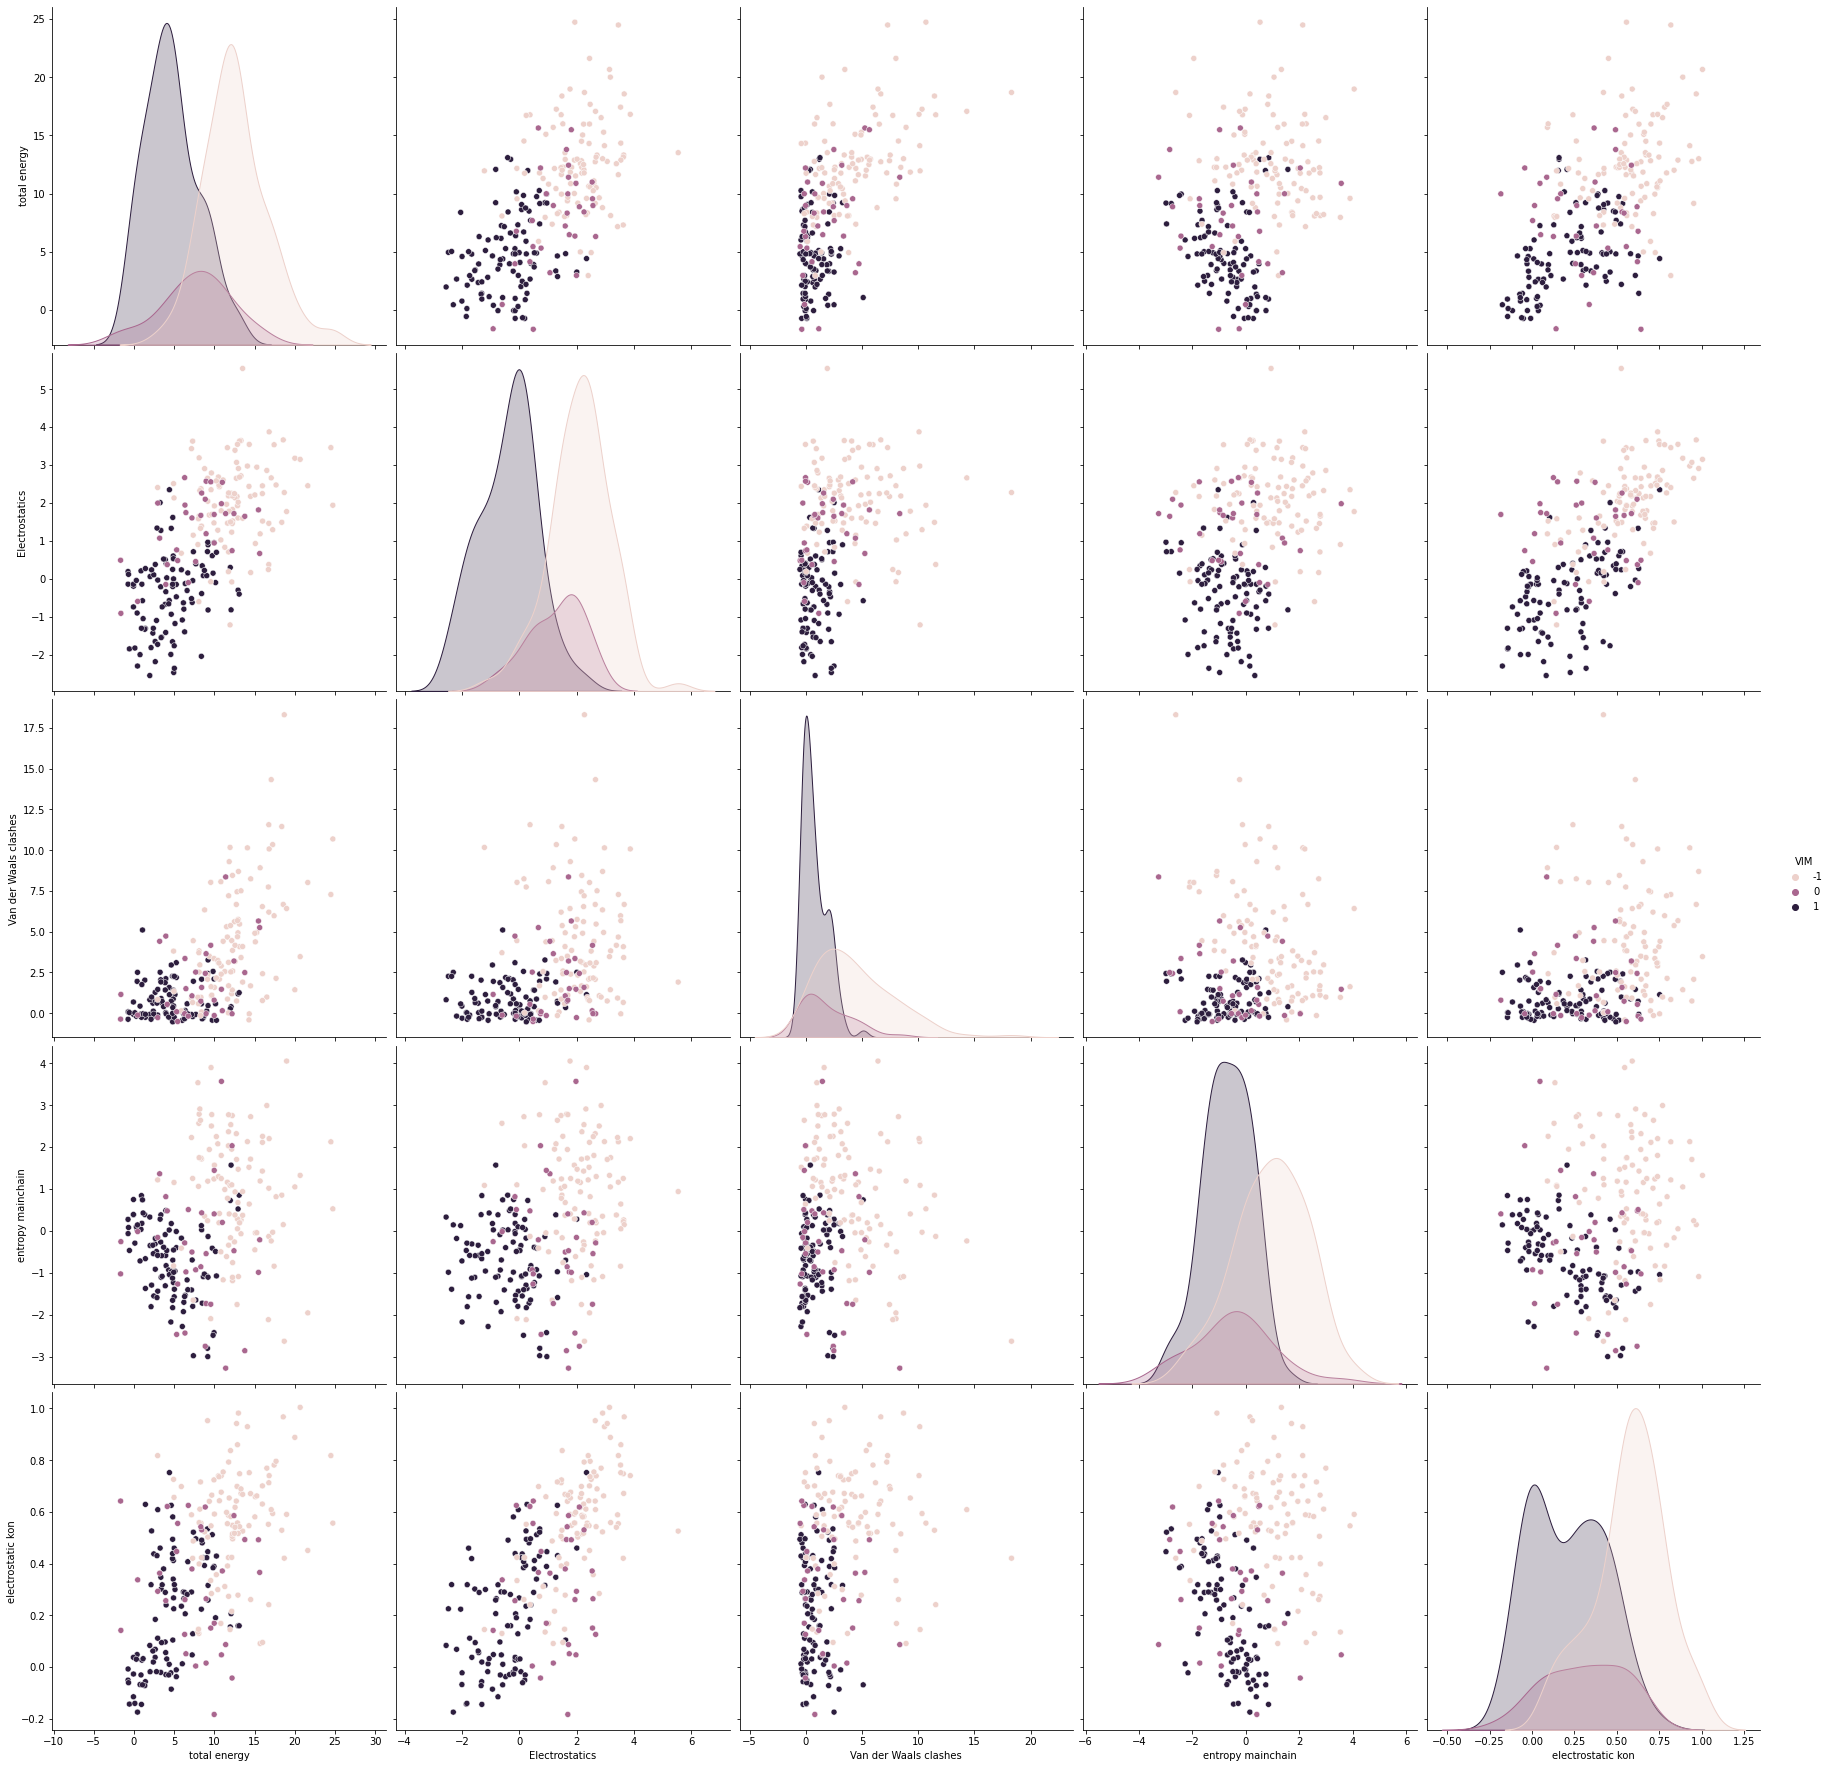

In [ ]:
#Aca agregamos tambien en la columna VIM el numero 0 para identificar a las candidatas (se pueden sacar a mano las positivas que se encuentran entre las candidatas para verlas en mas detalle)
sns.pairplot(tiw_cands,hue="VIM", height = 5)

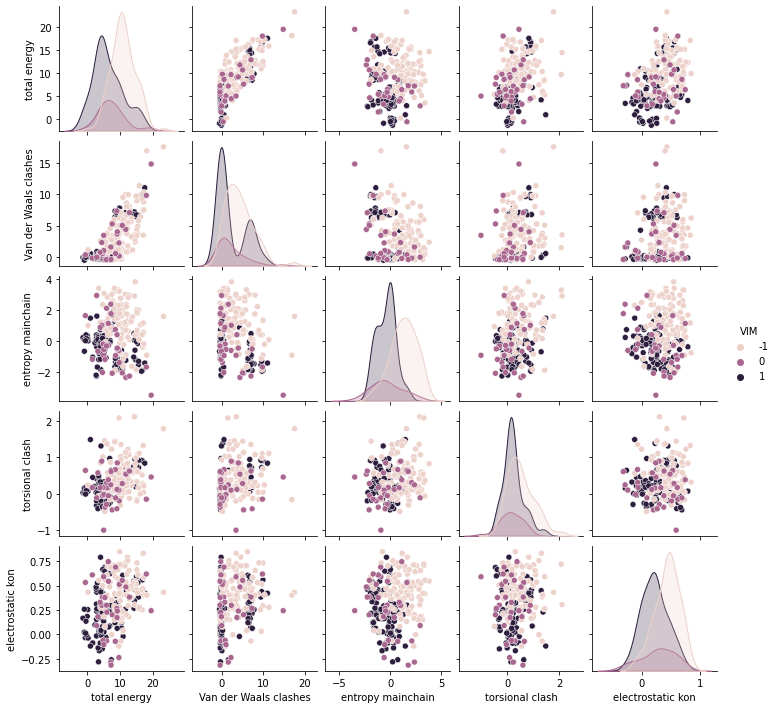

In [ ]:
sns.pairplot(kiw_cands,hue="VIM", height = 2)

In [ ]:
#Separo en conjuntos de test y entrenamiento

X_tiw_train, X_tiw_test, t_tiw_train, t_tiw_test = train_test_split(tiw.drop("VIM", axis=1), tiw["VIM"], test_size=0.20)
X_kiw_train, X_kiw_test, t_kiw_train, t_kiw_test = train_test_split(kiw.drop("VIM", axis=1), kiw["VIM"], test_size=0.20)

In [ ]:
pipeline = Pipeline([
        ("scaler", StandardScaler()), 
        ("rd_forest", RandomForestClassifier())])                      
#parametros_tiw = {'rd_forest__max_depth':[5,6,7], "rd_forest__max_leaf_nodes":[400, 450,500], "rd_forest__n_estimators":[500]}
parametros_tiw = {'rd_forest__max_depth':[5], "rd_forest__max_leaf_nodes":[400], "rd_forest__n_estimators":[500]}
gridtiw = GridSearchCV(pipeline, parametros_tiw, cv=20, refit=True)
gridtiw.fit(X_tiw_train, t_tiw_train) 
print('Best score: ',gridtiw.best_score_, gridtiw.best_params_)


#parametros_kiw = {'rd_forest__max_depth':[6,7,8], "rd_forest__max_leaf_nodes":[300, 350, 400], "rd_forest__n_estimators":[500]}
parametros_kiw = {'rd_forest__max_depth':[8], "rd_forest__max_leaf_nodes":[400], "rd_forest__n_estimators":[500]}
gridkiw = GridSearchCV(pipeline, parametros_kiw, cv=20, refit=True)
gridkiw.fit(X_kiw_train, t_kiw_train) 
print('Best score: ',gridkiw.best_score_, gridkiw.best_params_)

In [ ]:
#Vemos como dan los resultados en el conjunto de entrenamiento
confusio_tiw=confusion_matrix(t_tiw_test,gridtiw.predict(X_tiw_train))
print("RF hecho con tiw")
print("      pn    pp     (pp= predicho positivo, pn= predicho negativo)")
print("neg", confusio_tiw[0])
print("pos", confusio_tiw[1])
tn, fp, fn, tp = confusio_tiw.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%20.3f" % (tn/(tn+fp)))
print("Precision:%24.3f" % (tp/(tp+fp)))
print("FPR:%30.3f" % (fp/(tn+fp)))
print()
confusio_kiw=confusion_matrix(t_kiw_test,gridkiw.predict(X_kiw_train))
print("RF hecho con kiw")
print("      pn    pp     (pp= predicho positivo, pn= predicho negativo)")
print("neg", confusio_kiw[0])
print("pos", confusio_kiw[1])
tn, fp, fn, tp = confusio_kiw.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%20.3f" % (tn/(tn+fp)))
print("Precision:%24.3f" % (tp/(tp+fp)))
print("FPR:%30.3f" % (fp/(tn+fp)))

In [ ]:
#Y lo mismo en el de test
confusio_tiw=confusion_matrix(t_tiw_test,gridtiw.predict(X_tiw_test))
print("RF hecho con tiw")
print("      pn    pp     (pp= predicho positivo, pn= predicho negativo)")
print("neg", confusio_tiw[0])
print("pos", confusio_tiw[1])
tn, fp, fn, tp = confusio_tiw.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%20.3f" % (tn/(tn+fp)))
print("Precision:%24.3f" % (tp/(tp+fp)))
print("FPR:%30.3f" % (fp/(tn+fp)))
print()
confusio_kiw=confusion_matrix(t_kiw_test,gridkiw.predict(X_kiw_test))
print("RF hecho con kiw")
print("      pn    pp     (pp= predicho positivo, pn= predicho negativo)")
print("neg", confusio_kiw[0])
print("pos", confusio_kiw[1])
tn, fp, fn, tp = confusio_kiw.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%20.3f" % (tn/(tn+fp)))
print("Precision:%24.3f" % (tp/(tp+fp)))
print("FPR:%30.3f" % (fp/(tn+fp)))

In [ ]:
#Graficamos la importancia dada a cada parametro para ver si se correlacionan con lo que esperabamos.

pipeline = Pipeline([
        ("scaler", StandardScaler()), 
        ("rd_forest", RandomForestClassifier(max_depth = 6,max_leaf_nodes = 450, n_estimators = 500))])   
pipeline.fit(X_tiw_train, t_tiw_train)
imp = pipeline.named_steps["rd_forest"].feature_importances_.ravel()
plt.bar(list(tiw.drop("VIM", axis=1).columns), imp)
plt.xticks(rotation=90)
plt.title("importancia de los features de tiw")
plt.show()


pipeline = Pipeline([
        ("scaler", StandardScaler()), 
        ("rd_forest", RandomForestClassifier(max_depth = 7,max_leaf_nodes = 400, n_estimators = 500))])   
pipeline.fit(X_kiw_train, t_kiw_train)
imp = pipeline.named_steps["rd_forest"].feature_importances_.ravel()
plt.bar(list(kiw.drop("VIM", axis=1).columns), imp)
plt.xticks(rotation=90)
plt.title("importancia de los features de kiw")
plt.show()

In [ ]:
#Tomamos como criterio que se prediga positivo solo en los casos donde ambos modelos den una probabilidad mayor al 70%

positivos = list(zip([j for i,j in gridtiw.predict_proba(tiw[tiw["VIM"] == 1].drop("VIM", axis=1))],
                                                         [j for i,j in gridkiw.predict_proba(kiw[kiw["VIM"] == 1].drop("VIM", axis=1))]))
#print(positivos)
prediccion_pos = []
n = 0
umbral = 0.7
for i,j in positivos:
    n += 1
    if i > umbral and j > umbral:
        prediccion_pos.append((1))
    else:
        prediccion_pos.append((0))

negativos = list(zip([j for i,j in gridtiw.predict_proba(tiw[tiw["VIM"] == -1].drop("VIM", axis=1))],
                                                         [j for i,j in gridkiw.predict_proba(kiw[kiw["VIM"] == -1].drop("VIM", axis=1))]))
#print(positivos)
prediccion_neg = []
n = 0
umbral = 0.7
for i,j in negativos:
    n += 1
    if i > umbral and j > umbral:
        prediccion_neg.append((1))
    else:
        prediccion_neg.append((0))


#print(prediccion)
print("recall total: " + str(sum(prediccion_pos)*100/len(prediccion))+ "%")
print("especificidad total: " + str((len(prediccion) - sum(prediccion_neg))*100/len(prediccion)) + "%")

In [ ]:
#Vemos como dan los candidatos
list(zip(gridtiw.predict(tiw_solo_cands),gridkiw.predict(kiw_solo_cands)))
candidatas = list(zip([j for i,j in gridtiw.predict_proba(tiw_solo_cands)],[j for i,j in gridkiw.predict_proba(kiw_solo_cands)]))
#print(candidatas)
prediccion_cand = []
n = 0
umbral = 0.7
for i,j in candidatas:

    if i > umbral and j > umbral:
        prediccion_cand.append((n,1))
    else:
        prediccion_cand.append((0))
    n += 1
print(prediccion_cand)
lista_candidatas = ["LRRK2","CUL4B","|Q9H8Y5|ANKZ1_HUMAN","|Q9UKV5|AMFR_HUMAN","|Q9BQE4|SELS_HUMAN","|P21359|NF1_HUMAN","|Q8WV99|ZFN2B_HUMAN","|Q9BZV1|UBXN6_HUMAN","|Q8NHG7|SVIP_HUMAN","|Q92508|PIEZ1_HUMAN_1","|Q92508|PIEZ1_HUMAN_2","|P35658|NU214_HUMAN_1","|P35658|NU214_HUMAN_2","|A6NMB1|SIG16_HUMAN_1","|A6NMB1|SIG16_HUMAN_2","|Q9C029|TRIM7_HUMAN","|Q8N8E3|CE112_HUMAN","|Q96EK4|THA11_HUMAN_1","|Q96EK4|THA11_HUMAN_2","|Q96EK4|THA11_HUMAN_3","|Q9NX14|NDUBB_HUMAN_1","|Q9NX14|NDUBB_HUMAN_2","|Q9NX14|NDUBB_HUMAN_3","|Q9NVF7|FBX28_HUMAN","|Q6P575|BGP11_HUMAN","|Q96EA4|SPDLY_HUMAN","|P51955|NEK2_HUMAN","|Q9H840|GEMI7_HUMAN","|Q6UW49|SPESP_HUMAN","|Q96SC8|DMTA2_HUMAN","|Q6UXA7|CF015_HUMAN","|P50570|DYN2_HUMAN","|Q9NR33|DPOE4_HUMAN","|P0CJ78|ZN865_HUMAN","|Q9H213|MAGH1_HUMAN","|Q9NZ72|STMN3_HUMAN","|Q5T440|CAF17_HUMAN","|Q15834|CC85B_HUMAN"]
print("candidatas que pasan este criterio:")
print("     proteina              prediccion tiw  prediccion kiw")
for l in prediccion_cand:
  if isinstance(l, tuple):
    print("{0:<30s} {1:<15s} {2:<8s}".format(lista_candidatas[l[0]], str(round(candidatas[l[0]][0],4)), str(round(candidatas[l[0]][1],4))))

In [ ]:
list(zip(gridtiw.predict(tiw_puntajes),gridkiw.predict(kiw_puntajes)))
A = list(zip([j for i,j in gridtiw.predict_proba(tiw_puntajes)],[j for i,j in gridkiw.predict_proba(kiw_puntajes)]))
print(A)
B = []
n = 0
umbral = 0.7
for i,j in A:
    n += 1
    if i > umbral and j > umbral:
        B.append((1))
    else:
        B.append((0))
print(B)
C = []
n = 0
for i,j in A:
    n += 1
    if i > umbral or j > umbral:
        C.append((1))
    else:
        C.append((0))
print(C)